In [1]:
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def open_risk_free_yields() -> pd.DataFrame:
    """Load and process risk-free yield curve data from a CSV file.
    
    Reads a CSV file containing risk-free yield data, converts the date column
    to datetime objects, and returns the processed DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame containing the risk-free yield data with:
            - 'date' column as datetime objects
            - Other columns containing yield values for different maturities
            
    Note:
        Expects the CSV file to have a column named 'date' in '%Y-%m-%d' format.
        The file should be named 'risk_free_yields.csv' in the working directory.
    """
    df = pd.read_csv('risk_free_yields.csv')
    df["date"] = df.apply(lambda row: datetime.strptime(row["date"], "%Y-%m-%d"), axis=1)
    return df


def open_issuance_data() -> pd.DataFrame:
    """Load corporate bond issuance data from a CSV file.
    
    Returns:
        pd.DataFrame: Raw DataFrame containing bond issuance data as read from
        the 'issuance_data.csv' file in the working directory.
        
    Note:
        No preprocessing is applied to the data in this function.
    """
    df = pd.read_csv('issuance_data.csv')
    return df


def get_filenames_without_extension_os(directory_path: str) -> list[str]:
    """Get all filenames in a directory without their extensions.
    
    Args:
        directory_path: Path to the directory to scan for files.
        
    Returns:
        list[str]: List of filenames (without extensions) for all files
        found in the specified directory.
        
    Example:
        >>> get_filenames_without_extension_os('./data')
        ['file1', 'file2', 'notes']
    """
    filenames_without_ext = []
    for filename_with_ext in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename_with_ext)):
            name, ext = os.path.splitext(filename_with_ext)
            filenames_without_ext.append(name)
    return filenames_without_ext

In [3]:
risk_free_yields = open_risk_free_yields()
issuance_data = open_issuance_data()

In [4]:
files =  get_filenames_without_extension_os('./trade_data')


In [5]:
trades_dict = dict.fromkeys(files, "")
meta_dict = dict.fromkeys(files, "")

In [6]:
from typing import List, Union
import pandas as pd
import numpy as np
from datetime import datetime

def get_risk_free_yield(start_date: Union[datetime, str], to_maturity: float) -> float:
    """Get the risk-free yield for a specific date and maturity period.
    
    Finds the closest available risk-free yield data point for the given date 
    and maturity period by:
    1. Finding the nearest available date <= the start_date
    2. Finding the closest matching maturity period
    3. Returning the corresponding yield value
    
    Args:
        start_date: The target date (datetime object or ISO format string)
        to_maturity: The desired time to maturity in years
        
    Returns:
        float: The risk-free yield percentage for the closest matching date and period
        
    Raises:
        ValueError: If no date <= start_date is found in the data
        KeyError: If no matching maturity period column is found
        
    Example:
        >>> get_risk_free_yield('2023-01-15', 2.3)
        4.25  # returns yield for Jan 2023 and 2.5 year maturity
    """
    items = risk_free_yields['date'].to_numpy()
    closest_date = nearest_date(items, start_date)
    
    # Standard maturity periods available in the yield curve data
    periods = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 7.0, 10.0, 15.0]
    closest_period = get_closest_period(to_maturity, periods)
    
    column_name = get_col_name(closest_period)
    row = risk_free_yields.loc[risk_free_yields['date'] == closest_date]
    
    return row[column_name].values[0]


def get_col_name(period: float) -> str:
    """Generate the column name for a given maturity period.
    
    Args:
        period: The maturity period in years
        
    Returns:
        str: Column name in format 'period_X.Y' where X.Y is the period
        
    Example:
        >>> get_col_name(2.5)
        'period_2.5'
    """
    return 'period_' + str(period)


def get_closest_period(value: float, periods: List[float]) -> float:
    """Find the closest matching period from available standard periods.
    
    Args:
        value: Desired maturity period in years
        periods: List of available standard periods
        
    Returns:
        float: The closest available period to the requested value
        
    Example:
        >>> get_closest_period(2.3, [0.5, 1.0, 2.0, 2.5, 3.0])
        2.5
    """
    return min(periods, key=lambda x: abs(x - value))


def nearest_date(items: np.ndarray, pivot: Union[datetime, str]) -> datetime:
    """Find the nearest date in an array that is <= the pivot date.
    
    Args:
        items: Numpy array of datetime objects to search through
        pivot: Target date (datetime object or ISO format string)
        
    Returns:
        datetime: The closest date in the array that is <= pivot date
        
    Raises:
        ValueError: If no dates <= pivot date are found
        
    Example:
        >>> dates = np.array(['2023-01-01', '2023-02-01'], dtype='datetime64')
        >>> nearest_date(dates, '2023-01-15')
        numpy.datetime64('2023-01-01')
    """
    if isinstance(pivot, str):
        pivot = np.datetime64(pivot)
    
    valid_dates = [i for i in items if i <= pivot]
    if not valid_dates:
        raise ValueError(f"No dates found <= {pivot}")
    
    return min(valid_dates, key=lambda x: abs(x - pivot))

In [7]:
def calculate_ytm(row: pd.Series, coupon: float) -> float:
    """Calculate the approximate Yield to Maturity (YTM) for a bond.
    
    Uses a simplified formula to estimate YTM, which is the internal rate of return
    earned by an investor who buys the bond at its current market price and holds 
    it until maturity, assuming all coupon payments are made as scheduled.
    
    The formula used is:
    YTM ≈ [Coupon + ((Face Value - Present Value) / Years to Maturity)] / [(Face Value + Present Value)/2]
    
    Args:
        row: A pandas Series containing bond information with:
            - "ohlc4": Current market price of the bond (average of OHLC prices)
            - "toMaturity": Time to maturity in years
        coupon: The annual coupon payment as a percentage of face value
        
    Returns:
        float: The estimated yield to maturity as a percentage (e.g., 5.25 for 5.25%)
        
    Example:
        >>> bond_data = pd.Series({"ohlc4": 95.0, "toMaturity": 2.5})
        >>> calculate_ytm(bond_data, 4.0)  # 4% coupon
        5.384615384615384  # Returns ~5.38% YTM
        
    Note:
        This is an approximation that assumes:
        1. Coupon payments are made annually
        2. The bond is held to maturity
        3. The time value of money is not precisely accounted for
        For more precise calculations, consider using numpy_financial.irr or similar
    """
    face_value = 100  # Standard bond face value
    present_value = row["ohlc4"]
    avg_price = (face_value + present_value) / 2
    years_to_maturity = row["toMaturity"]
    
    # Calculate approximate YTM using simplified formula
    ytm = (coupon + (face_value - present_value) / years_to_maturity) / avg_price
    
    # Convert to percentage
    return ytm * 100

In [8]:
def process_trade_data(meta: pd.DataFrame) -> pd.DataFrame:
    """Process bond trade data by enriching it with calculated metrics.
    
    Loads trade data for a specific bond and calculates several derived metrics:
    - OHLC4 average price (average of Open, High, Low, Close)
    - Proper datetime conversion
    - Time to maturity in years
    - Risk-free yield for corresponding maturity
    - Yield to Maturity (YTM)
    - Risk premium (YTM - risk-free yield)
    
    Args:
        meta: DataFrame containing bond metadata with:
            - "Название": Bond name (used to locate trade data file)
            - "dateEnd": Maturity date in '%Y-%m-%d' format
            - "effYield": Effective yield (coupon rate) as percentage
            
    Returns:
        pd.DataFrame: Processed DataFrame with original trade data plus:
            - ohlc4: Average of OHLC prices
            - date: Proper datetime object from trade date
            - dateEnd: Maturity date as datetime
            - toMaturity: Years remaining to maturity
            - risk_free_yield: Corresponding risk-free rate
            - ytm: Calculated yield to maturity
            - premium: Risk premium (ytm - risk_free_yield)
            
    Raises:
        FileNotFoundError: If trade data file cannot be found
        KeyError: If required columns are missing in meta or trade data
        ValueError: If date formats are incorrect
        
    Example:
        >>> meta = pd.DataFrame({
        ...     "Название": ["RU000A0JX0J0"],
        ...     "dateEnd": ["2025-05-14"],
        ...     "effYield": [7.5]
        ... })
        >>> processed_data = process_trade_data(meta)
        >>> processed_data.columns
        Index(['<DATE>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', 'ohlc4', 'date',
               'dateEnd', 'toMaturity', 'risk_free_yield', 'ytm', 'premium'],
              dtype='object')
    """
    # Extract bond name from metadata
    name = meta["Название"].values[0]
    
    try:
        # Load trade data with DATE column as string to preserve leading zeros
        df = pd.read_csv(f'./trade_data/{name}.csv', dtype={'<DATE>': object})
        
        # Calculate average price from OHLC values
        df["ohlc4"] = (df["<CLOSE>"] + df["<OPEN>"] + df["<HIGH>"] + df["<LOW>"]) / 4
        
        # Convert trade date from 'DDMMYY' string to datetime
        df["date"] = df.apply(
            lambda row: datetime.strptime(str(row["<DATE>"]), "%d%m%y"), 
            axis=1
        )
        
        # Add maturity date from metadata (constant for all rows)
        maturity_date = meta["dateEnd"].values[0]
        df["dateEnd"] = df.apply(
            lambda row: datetime.strptime(maturity_date, "%Y-%m-%d"), 
            axis=1
        )
        
        # Calculate time to maturity in years
        df["toMaturity"] = df.apply(
            lambda row: (row["dateEnd"] - row["date"]).days / 365, 
            axis=1
        )
        
        # Get risk-free yield for corresponding date and maturity
        df["risk_free_yield"] = df.apply(
            lambda row: get_risk_free_yield(row["date"], row["toMaturity"]), 
            axis=1
        )
        
        # Calculate yield to maturity using effective yield from metadata
        df["ytm"] = df.apply(
            lambda row: calculate_ytm(row, meta["effYield"].values[0]), 
            axis=1
        )
        
        # Calculate risk premium (spread over risk-free rate)
        df["premium"] = df["ytm"] - df["risk_free_yield"]
        
        return df
        
    except FileNotFoundError:
        raise FileNotFoundError(f"Trade data file not found: ./trade_data/{name}.csv")
    except KeyError as e:
        raise KeyError(f"Missing required column: {str(e)}")
    except ValueError as e:
        raise ValueError(f"Date format error: {str(e)}")


In [9]:
for key in meta_dict.keys():
    meta_dict[key] = issuance_data[ issuance_data["Название"] == key]

In [10]:
for key in trades_dict.keys():
    trades_dict[key] = process_trade_data(meta_dict[key])

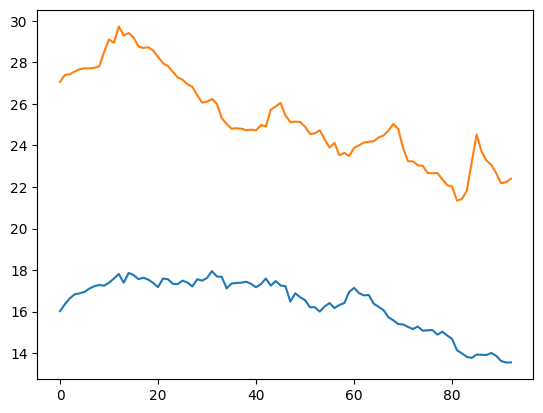

In [11]:
plt.plot(trades_dict["NSKATD-03"]["risk_free_yield"])
plt.plot(trades_dict["NSKATD-03"]["ytm"])

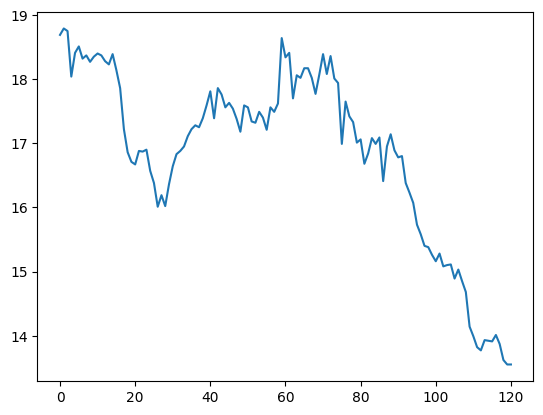

In [12]:
plt.plot(trades_dict["ГТЛК 2P-07"]["risk_free_yield"])

In [13]:
average_premium = np.zeros(30)

In [ ]:
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    for key in trades_dict:
        local_premium = trades_dict[key].iloc[i]["premium"]
        premium += local_premium / tickers
    average_premium[i] = premium

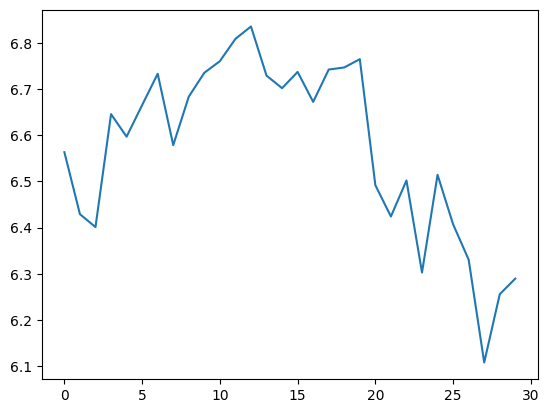

In [70]:
plt.plot(average_premium)

In [17]:
for key in trades_dict.keys():
    starting_premium = trades_dict[key]["premium"].iloc[0]
    trades_dict[key]["relative_premium"] = trades_dict[key]["premium"] / starting_premium

In [ ]:
# Calculating relative average premium
average_relative_premium = np.zeros(30)
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    for key in trades_dict:
        local_premium = trades_dict[key].iloc[i]["relative_premium"]
        premium += local_premium / tickers
    average_relative_premium[i] = premium

Text(0.5, 1.0, 'Relative Premium Across All Issuance')

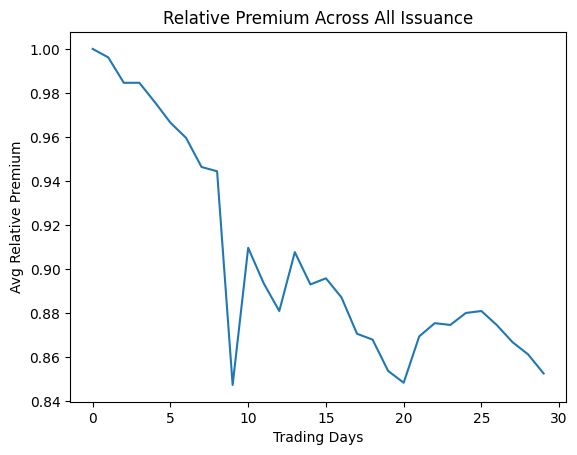

In [26]:
fig, ax = plt.subplots()
ax.plot(average_relative_premium)
ax.set_xlabel("Trading Days")
ax.set_ylabel("Avg Relative Premium")
ax.set_title("Relative Premium Across All Issuance")

In [27]:
ratings = {
    'AA': 1,
    "A": 2,
    "BBB": 3,
    "BB": 4,
    "BB-": 5,
    "B+": 6,
    "B": 7,
}

In [57]:
# Calculating relative average premium
average_relative_premium = np.zeros(30)
for i in range(30):
    premium = 0
    tickers = len(trades_dict)
    num_tickers = 0
    for key in meta_dict:
        if (meta_dict[key]["Объем"].values[0] >1000 and meta_dict[key]["Объем"].values[0] >5000):
            local_premium = trades_dict[key].iloc[i]["relative_premium"]
            premium += local_premium
            num_tickers+=1
    premium/=num_tickers
    average_relative_premium[i] = premium
    print(premium)
    print(num_tickers)

1.0
41
1.0293390155272077
41
0.9957499115816179
41
0.9970278443392177
41
0.9804886134389579
41
0.9643357126068354
41
0.9515370399284842
41
0.9281278625810244
41
0.9340315895741459
41
0.87717597880317
41
0.849646310524883
41
0.8089582858822157
41
0.7783828648026052
41
0.859964431055849
41
0.8266700880442623
41
0.822738535018505
41
0.805525174611525
41
0.8190897352873652
41
0.8124941735455309
41
0.7915891932720364
41
0.7803065419604922
41
0.7602528982677156
41
0.759939056445938
41
0.7268807307029874
41
0.7913650829930856
41
0.7892350988768448
41
0.7766688423044791
41
0.7585308692259469
41
0.7385561214635196
41
0.7316947741784491
41


Text(0.5, 1.0, 'Relative Premium Across Issues >5000')

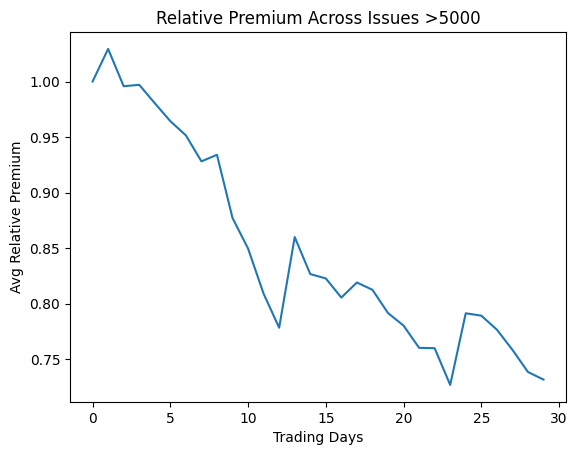

In [58]:
fig, ax = plt.subplots()
ax.plot(average_relative_premium)
ax.set_xlabel("Trading Days")
ax.set_ylabel("Avg Relative Premium")
ax.set_title("Relative Premium Across Issues >5000")

In [85]:
number_of_issues = np.zeros([7, 5])
avg_premium_30d = np.zeros([7, 5])

3

In [87]:
# Calculating relative average premium
for key in meta_dict:
    i = meta_dict[key]["numRating"].values[0] -1
    volume = meta_dict[key]["Объем"].values[0]
    j = datetime.strptime(meta_dict[key]["dateStart"].values[0], "%Y-%m-%d").month -1
    premium = trades_dict[key]["relative_premium"].iloc[29]
    number_of_issues[i, j]+=1
    avg_premium_30d[i, j]+=premium

In [88]:
print(avg_premium_30d/number_of_issues)
print(number_of_issues)

[[0.68145159 0.64814612 0.21178638 1.05314345 0.53033138]
 [1.04277723        nan 0.57662368 0.73880315        nan]
 [       nan 0.90236515 0.79053108 0.80433903 0.86782376]
 [       nan 0.98855348 0.8399708  0.9387497  0.93743581]
 [1.00497965 0.89416663 0.92176852 0.95668456 0.96315518]
 [       nan 1.13438113 0.96455246 0.98724836 1.06921241]
 [1.04841651 1.02984991 0.95276906 0.91791777 0.93951537]]
[[ 4. 14.  5.  4.  4.]
 [ 1.  0.  2.  1.  0.]
 [ 0.  4.  5.  3.  2.]
 [ 0.  5. 11.  8.  2.]
 [ 3.  1.  3.  2.  2.]
 [ 0.  2.  4.  3.  3.]
 [ 2.  8.  8.  5.  3.]]


C:\Users\igorp\AppData\Local\Temp\ipykernel_6560\4155610227.py:1: RuntimeWarning: invalid value encountered in divide
  print(avg_premium_30d/number_of_issues)


In [ ]:
avg_premium_30d /= number_of_issues

C:\Users\igorp\AppData\Local\Temp\ipykernel_6560\2042011141.py:1: RuntimeWarning: invalid value encountered in divide
  avg_premium_30d /= number_of_issues


In [71]:
avg_premium_30d

array([[ 0.79659485, -0.16282841,  0.66863376],
       [        nan,  0.56981625,  0.78833717],
       [        nan,  0.80914491,  0.88569528],
       [ 0.70680729,  0.93962943,  0.87090061],
       [ 0.90874971,  0.94527098,  1.0006501 ],
       [ 1.04636218,  0.98136425,         nan],
       [ 0.99703558,  0.87935222,         nan]])